In [16]:
# basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#tensorflow
import tensorflow as tf
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout

import tensorflow_probability as tfp
tfd = tfp.distributions

# others
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from copy import deepcopy
from xgboost import XGBRegressor

# Variables from config file
from config import BASE_DIR, FILE_NAMES, LABELS, ATTRIBUTES, BEST_MODEL_COLUMNS, ISLAND_RANGES

In [2]:
# Split the stations by the number of samples available
columns = deepcopy(LABELS)
columns.extend(["season_wet", "elevation", "lat", "lon"])
for item in columns:
    print(item, end=' ')

# # load datasets
# df_train = pd.read_csv(f"{BASE_DIR}/train.csv", usecols=columns + ['year', 'month', 'skn', 'data_in'])
# df_valid = pd.read_csv(f"{BASE_DIR}/valid.csv", usecols=columns + ['year', 'month', 'skn', 'data_in'])
# df_test = pd.read_csv(f"{BASE_DIR}/test.csv", usecols=columns + ['year', 'month', 'skn', 'data_in'])
# df_combined = pd.concat([df_train, df_valid, df_test])

air2m air1000_500 hgt500 hgt1000 omega500 pottemp1000-500 pottemp1000-850 pr_wtr shum-uwnd-700 shum-uwnd-925 shum-vwnd-700 shum-vwnd-950 shum700 shum925 skt slp season_wet elevation lat lon 

In [3]:
df_load = pd.read_csv(f"{BASE_DIR}/nonfilled_dataset.csv")

# inner join with valid station (more than 300 stations)
threshold = 300
df_skn = df_load.groupby('skn').size().reset_index().rename(columns={0: "n_samples"})
df_skn_valid = df_skn[df_skn['n_samples'] > threshold]

df_data = df_load.merge(right=df_skn_valid, left_on='skn', right_on='skn')

In [4]:
def root_mean_squared_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def define_model(num_inputs=20, lr=0.0065):
    inputs = Input(shape=(num_inputs,))
    x = Dense(units=20, activation='relu')(inputs)
    # x = Dense(units=16, activation='relu')(inputs)
    x = Dense(units=8, activation='relu')(x)
    x = Dense(units=4, activation='relu')(x)
    outputs = Dense(units=1, kernel_initializer='normal')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=lr),
        loss='mse',
        metrics=[RootMeanSquaredError()]
    )
    
    return model

# Try testing on a single station with simple single train/valid/test split

In [258]:
skn = df_data['skn'].sample().values[0]
print(f'{skn}')
df_station = df_data[df_data['skn'] == skn]

X = np.array(df_station[columns])
Y = np.array(df_station['data_in'])

Xtemp, Xtest, Ytemp, Ytest = train_test_split(X, Y, test_size=0.2, shuffle=False)
Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(Xtemp, Ytemp, test_size=0.2, shuffle=False)

scaler = StandardScaler()

Xtrain = scaler.fit_transform(Xtrain)
Xvalid = scaler.transform(Xvalid)
Xtest = scaler.transform(Xtest)

1114.0


In [259]:
model = define_model()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5, mode='min')
epochs=20

history = model.fit(
    Xtrain, Ytrain, 
    epochs=epochs, 
    validation_data = (Xvalid, Yvalid),
    callbacks=[callback],
    batch_size=64,
    verbose=0
)

yhat = model.predict(Xtest)
print(mean_squared_error(Ytest, yhat, squared=False))

2.6401822684077336


In [260]:
linear_regression = LinearRegression()
linear_regression.fit(Xtrain, Ytrain)
yhat = linear_regression.predict(Xtest)

print(mean_squared_error(Ytest, yhat, squared=False))

2.839487093427457


In [261]:

params = {'n_estimators': 260, 'learning_rate': 0.1, 'max_depth': 3, 'early_stopping_rounds': 8, 'verbosity': 0}
xgboost = XGBRegressor(**params)

xgboost.fit(Xtrain, Ytrain)
yhat = xgboost.predict(Xtest)
print(mean_squared_error(Ytest, yhat, squared=False))

3.12209866513206


# Looks good. Now implement cross_val_predict for the NN model

In [21]:
def cross_val_predict_for_nn(model, X, Y, callback, batch_size, epochs, verbose):
    kf = KFold(n_splits=5)
    y_pred = []

    for train_index, test_index in kf.split(X):
        Xtemp, Xtest = X[train_index], X[test_index]
        Ytemp, Ytest = Y[train_index], Y[test_index]
        
        Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(Xtemp, Ytemp, test_size=0.2, shuffle=True)
        # print(Xtrain.shape, Xvalid.shape, Xtest.shape)
        
        # scale the input
        scaler = StandardScaler()
        Xtrain = scaler.fit_transform(Xtrain)
        Xvalid = scaler.transform(Xvalid)
        Xtest = scaler.transform(Xtest)
        
        model.fit(
            Xtrain, Ytrain, epochs=epochs,
            validation_data = (Xvalid, Yvalid),
            callbacks=[callback],
            batch_size=batch_size,
            verbose=verbose
        )
        y_pred.extend(model.predict(Xtest).tolist())
    
    return np.array(y_pred)

In [315]:
skn = df_data['skn'].sample().values[0]
print(f'{skn}')
df_station = df_data[df_data['skn'] == skn]

X = np.array(df_station[columns])
Y = np.array(df_station['data_in'])

model = define_model()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3, mode='min')
epochs=20
batch_size=64

yhat = cross_val_predict_for_nn(model, X, Y, callback, batch_size, epochs, verbose=0)
mean_squared_error(Y, yhat, squared=False)

2.0


2.271283341053673

In [316]:
yhat = cross_val_predict(LinearRegression(), X, Y, n_jobs=-1)
mean_squared_error(Y, yhat, squared=False)

2.1039270543980253

In [12]:
df_data['skn'].unique().shape

(550,)

In [13]:
# try on ten random stations
list_df_results = []
# n_samples = 100
# skns = df_data['skn'].sample(n=n_samples).values
params = {'n_estimators': 260, 'learning_rate': 0.1, 'max_depth': 3, 'early_stopping_rounds': 8, 'verbosity': 0}
skns = df_data['skn'].unique()
n_samples = skns.shape[0]
for i, skn in enumerate(skns):
    df_station = df_data[df_data['skn'] == skn]

    X = np.array(df_station[columns])
    Y = np.array(df_station['data_in'])

    model = define_model()
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3, mode='min')
    epochs=20
    batch_size=64

    yhat_nn = cross_val_predict_for_nn(model, X, Y, callback, batch_size, epochs, verbose=0)
    rmse_nn = mean_squared_error(Y, yhat_nn, squared=False)
    
    yhat_lr = cross_val_predict(LinearRegression(), X, Y, n_jobs=-1)
    rmse_lr = mean_squared_error(Y, yhat_lr, squared=False)
    
    yhat_xgb = cross_val_predict(XGBRegressor(**params), X, Y, n_jobs=-1)
    rmse_xgb = mean_squared_error(Y, yhat_xgb, squared=False)
    
    list_df_results.append(
        pd.DataFrame({
            "skn": [skn] * df_station.shape[0],
            "data_in": Y,
            "pred_nn": yhat_nn.reshape(-1,),
            "pred_lr": yhat_lr,
            "pred_xgb": yhat_xgb
        })
    )
    #print(f"SKN: {skn}")
    #print("RMSE on NN : {:.3f}\nRMSE on LR : {:.3f}\nRMSE on XGB: {:.3f}".format(rmse_nn, rmse_lr, rmse_xgb))
    print(f"{i}/{n_samples}", end='\r')
df_results = pd.concat(list_df_results)

In [21]:
df_results.to_csv(f"{BASE_DIR}/NN/base_model_result.csv", index=False)

<hr>

In [4]:
df_results = pd.read_csv(f"{BASE_DIR}/NN/base_model_result.csv")

In [5]:
rmse_nn = mean_squared_error(df_results['data_in'], df_results['pred_nn'], squared=False)
rmse_lr = mean_squared_error(df_results['data_in'], df_results['pred_lr'], squared=False)
rmse_xgb = mean_squared_error(df_results['data_in'], df_results['pred_xgb'], squared=False)

rmse_nn, rmse_lr, rmse_xgb

(3.4360513726657063, 3.4597299840862576, 3.7356976071956907)

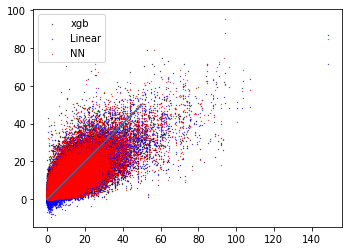

In [6]:
fig, ax = plt.subplots(1)
ax.scatter(df_results['data_in'], df_results['pred_xgb'], s=0.1, color='k', label='xgb')
ax.scatter(df_results['data_in'], df_results['pred_lr'], s=0.1, color='b', label='Linear')
ax.scatter(df_results['data_in'], df_results['pred_nn'], s=0.1, color='r', label='NN')
ax.plot([0, 50], [0, 50])
ax.set_aspect('equal')
ax.legend()

In [7]:
df_results_per_station = (
    df_results.groupby('skn')
    .apply(lambda group: mean_squared_error(group['data_in'], group['pred_nn'], squared=False))
    .reset_index()
    .rename(columns={0: "rmse"})
    .sort_values("rmse")
)

<AxesSubplot:>

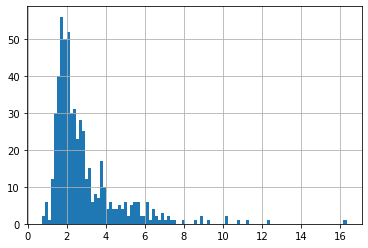

In [8]:
df_results_per_station['rmse'].hist(bins=100)

# Try heteroskedastic regression

In [80]:
def define_hetero_model(num_inputs=20, lr=0.0065):
    inputs = Input(shape=(num_inputs,))
    x = Dense(units=16, activation='relu', kernel_initializer='normal')(inputs)
    x = Dense(units=12, activation='relu', kernel_initializer='normal')(x)
    x = Dense(units=8, activation='relu', kernel_initializer='normal')(x)
#    x = Dropout(rate=0.3)(x)
    
    m = Dense(units=4, activation='relu', kernel_initializer='normal')(x)
#    m = Dropout(rate=0.3)(m)
    m = Dense(units=1, activation='linear', kernel_initializer='normal')(m)
    
    s = Dense(units=4, activation='relu', kernel_initializer='normal')(x)
#    s = Dropout(rate=0.3)(s)
    s = Dense(units=1, activation='linear', kernel_initializer='normal')(s)
    
    ms = Concatenate(axis=-1)([m, s])
    outputs = tfp.layers.DistributionLambda(
        make_distribution_fn=lambda t: tfd.Normal(
            loc=t[...,0], scale=tf.math.softplus(t[...,1])#scale=tf.exp(t[..., 1])
        ),
        convert_to_tensor_fn=lambda s: s.mean()
    )(ms)
    # print(type(outputs))
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=lr),
        loss=lambda y, p_y: -p_y.log_prob(y),
        metrics=[RootMeanSquaredError()]
    )
    
    return model

In [81]:
skn = df_data['skn'].sample().values[0]
df_station = df_data[df_data['skn'] == skn]
print(f'station {skn} has {df_station.shape[0]} samples')
lr = 0.003

X = np.array(df_station[columns[:-3]])
Y = np.array(df_station['data_in'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3, mode='min')
epochs=20
batch_size=64
preds = []
rmses = []
for i in range(5):
    print(f"round {i}", end='\r')
    model = define_hetero_model(num_inputs=len(columns[:-3]), lr=lr)
    yhat = cross_val_predict_for_nn(model, X, Y, callback, batch_size, epochs, verbose=0)
    preds.append(yhat)
    rmse = mean_squared_error(Y, yhat, squared=False)
    rmses.append(rmse)
    print(rmse)
yhat = np.array(preds).mean(axis=0)
    
print("overall:", mean_squared_error(Y, yhat, squared=False))
print("avg rmse", np.array(rmses).mean())

station 774.1 has 431 samples
3.7926162998934854
4.034172788431675
3.3909840519720076
4.089041209360951
3.9939947605864234
overall: 3.7057628832079876
avg rmse 3.8601618220489087


In [82]:
print(f'{skn}')
df_station = df_data[df_data['skn'] == skn]

X = np.array(df_station[columns])
Y = np.array(df_station['data_in'])

model = define_model(lr=lr)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3, mode='min')
epochs=20
batch_size=64

yhat = cross_val_predict_for_nn(model, X, Y, callback, batch_size, epochs, verbose=0)
mean_squared_error(Y, yhat, squared=False)

774.1


3.4411540812463293

In [83]:
print(f'{skn}')
df_station = df_data[df_data['skn'] == skn]

X = np.array(df_station[columns])
Y = np.array(df_station['data_in'])

model = LinearRegression()

# yhat = cross_val_predict_for_nn(model, X, Y, callback, batch_size, epochs, verbose=0)
yhat = cross_val_predict(model, X, Y)
mean_squared_error(Y, yhat, squared=False)

774.1


3.342773090850899

In [87]:
# try on ten random stations
list_df_results = []
n_samples = 100
skns = df_data['skn'].sample(n=n_samples).values
params = {'n_estimators': 260, 'learning_rate': 0.1, 'max_depth': 3, 'early_stopping_rounds': 8, 'verbosity': 0}
# skns = df_data['skn'].unique()
n_samples = skns.shape[0]
for i, skn in enumerate(skns):
    df_station = df_data[df_data['skn'] == skn]

    X = np.array(df_station[columns])
    Y = np.array(df_station['data_in'])

    model = define_hetero_model()
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3, mode='min')
    epochs=20
    batch_size=64

    yhat_hetero = cross_val_predict_for_nn(model, X, Y, callback, batch_size, epochs, verbose=0)
    rmse_hetero = mean_squared_error(Y, yhat_hetero, squared=False)
    
    # yhat_lr = cross_val_predict(LinearRegression(), X, Y, n_jobs=-1)
    # rmse_lr = mean_squared_error(Y, yhat_lr, squared=False)
    
    # yhat_xgb = cross_val_predict(XGBRegressor(**params), X, Y, n_jobs=-1)
    # rmse_xgb = mean_squared_error(Y, yhat_xgb, squared=False)
    
    model = define_model()
    yhat_vanila = cross_val_predict_for_nn(model, X, Y, callback, batch_size, epochs, verbose=0)
    rmse_vanila = mean_squared_error(Y, yhat_vanila, squared=False)
    
    
    list_df_results.append(
        pd.DataFrame({
            "skn": [skn] * df_station.shape[0],
            "data_in": Y,
            "pred_hetero": yhat_hetero.reshape(-1,),
            "pred_valina": yhat_vanila.reshape(-1,),
        })
    )
    #print(f"SKN: {skn}")
    #print("RMSE on NN : {:.3f}\nRMSE on LR : {:.3f}\nRMSE on XGB: {:.3f}".format(rmse_nn, rmse_lr, rmse_xgb))
    print(f"{i}/{n_samples}", end='\r')
df_results = pd.concat(list_df_results)

In [89]:
df_results.groupby('skn').apply(lambda group: mean_squared_error(group['data_in'], group['pred_hetero']))

skn
14.0       7.931480
39.0       1.922409
54.0      21.563302
58.0      26.233462
58.1      24.297456
            ...    
1092.0    17.259858
1110.0     7.644320
1115.0    32.387569
1133.0    13.111475
1145.0     7.018441
Length: 87, dtype: float64

In [90]:
mean_squared_error(df_results['data_in'], df_results['pred_hetero'], squared=False)

4.015111003602443

In [93]:
mean_squared_error(df_results['data_in'], df_results['pred_valina'], squared=False)

3.877957796209424

# What if we use grid data?

In [95]:
reanalysis_data = [
    'air2m', 'air1000_500', 'hgt500', 'hgt1000', 'omega500',
    'pottemp1000-500', 'pottemp1000-850', 'pr_wtr', 'shum-uwnd-700',
    'shum-uwnd-925', 'shum-vwnd-700', 'shum-vwnd-950', 'shum700', 'shum925', 
    'skt', 'slp'
]

columns = []
for i in range(6):
    for item in reanalysis_data:
        columns.append(f"{item}_{i}")

columns.extend(['lat', 'lon', 'elevation', 'season_wet', 'season_dry'])
for item in columns:
    print(item, end=' ')

air2m_0 air1000_500_0 hgt500_0 hgt1000_0 omega500_0 pottemp1000-500_0 pottemp1000-850_0 pr_wtr_0 shum-uwnd-700_0 shum-uwnd-925_0 shum-vwnd-700_0 shum-vwnd-950_0 shum700_0 shum925_0 skt_0 slp_0 air2m_1 air1000_500_1 hgt500_1 hgt1000_1 omega500_1 pottemp1000-500_1 pottemp1000-850_1 pr_wtr_1 shum-uwnd-700_1 shum-uwnd-925_1 shum-vwnd-700_1 shum-vwnd-950_1 shum700_1 shum925_1 skt_1 slp_1 air2m_2 air1000_500_2 hgt500_2 hgt1000_2 omega500_2 pottemp1000-500_2 pottemp1000-850_2 pr_wtr_2 shum-uwnd-700_2 shum-uwnd-925_2 shum-vwnd-700_2 shum-vwnd-950_2 shum700_2 shum925_2 skt_2 slp_2 air2m_3 air1000_500_3 hgt500_3 hgt1000_3 omega500_3 pottemp1000-500_3 pottemp1000-850_3 pr_wtr_3 shum-uwnd-700_3 shum-uwnd-925_3 shum-vwnd-700_3 shum-vwnd-950_3 shum700_3 shum925_3 skt_3 slp_3 air2m_4 air1000_500_4 hgt500_4 hgt1000_4 omega500_4 pottemp1000-500_4 pottemp1000-850_4 pr_wtr_4 shum-uwnd-700_4 shum-uwnd-925_4 shum-vwnd-700_4 shum-vwnd-950_4 shum700_4 shum925_4 skt_4 slp_4 air2m_5 air1000_500_5 hgt500_5 hgt1

In [8]:
# load datasets
df_train = pd.read_csv(f"{BASE_DIR}/train.csv")
df_valid = pd.read_csv(f"{BASE_DIR}/valid.csv")
df_test = pd.read_csv(f"{BASE_DIR}/test.csv")
df_combined = pd.concat([df_train, df_valid, df_test])

In [114]:
skn = df_combined['skn'].sample().values[0]
df_station = df_combined[df_combined['skn'] == skn]
print(f'station {skn} has {df_station.shape[0]} samples')
lr = 0.003

X = np.array(df_station[columns[:-3]])
Y = np.array(df_station['data_in'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3, mode='min')
epochs=20
batch_size=64
preds = []
rmses = []
for i in range(5):
    print(f"round {i}", end='\r')
    model = define_hetero_model(num_inputs=len(columns[:-3]), lr=lr)
    yhat = cross_val_predict_for_nn(model, X, Y, callback, batch_size, epochs, verbose=0)
    preds.append(yhat)
    rmse = mean_squared_error(Y, yhat, squared=False)
    rmses.append(rmse)
    print(rmse)
yhat = np.array(preds).mean(axis=0)
    
print("overall:", mean_squared_error(Y, yhat, squared=False))
print("avg rmse", np.array(rmses).mean())

station 682.0 has 720 samples
2.081006049528605
2.0433804833535776
3.352129575951407
2.0750106741025838
2.047769701340767
overall: 2.097688875108001
avg rmse 2.3198592968553884


In [115]:
print(f'{skn}')
df_station = df_combined[df_combined['skn'] == skn]

X = np.array(df_station[columns])
Y = np.array(df_station['data_in'])

model = define_model(lr=lr, num_inputs=len(columns))
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3, mode='min')
epochs=20
batch_size=64

yhat = cross_val_predict_for_nn(model, X, Y, callback, batch_size, epochs, verbose=0)
mean_squared_error(Y, yhat, squared=False)

682.0


1.9793833960941611

In [116]:
print(f'{skn}')
df_station = df_combined[df_combined['skn'] == skn]

X = np.array(df_station[columns])
Y = np.array(df_station['data_in'])

model = LinearRegression()

# yhat = cross_val_predict_for_nn(model, X, Y, callback, batch_size, epochs, verbose=0)
yhat = cross_val_predict(model, X, Y)
mean_squared_error(Y, yhat, squared=False)

682.0


2.158795735053062

In [ ]:
results = []
n_stations = df_combined['skn'].unique().shape[0]
for i, skn in enumerate(df_combined['skn'].unique()):
    df_station = df_combined[df_combined['skn'] == skn]
    if df_station.shape[0] <= 5: continue
        
    df_station = df_station.sort_values(by=['year', 'month'])
        
    X = np.array(df_station[columns])
    Y = np.array(df_station['data_in'])

    model = define_model(lr=lr, num_inputs=len(columns))
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3, mode='min')
    epochs=20
    batch_size=64

    yhat_nn = cross_val_predict_for_nn(model, X, Y, callback, batch_size, epochs, verbose=0)
    
    model = LinearRegression()
    yhat_lr = cross_val_predict(model, X, Y)

    results.append(
        pd.DataFrame(
            {
                "skn": [skn for _ in range(X.shape[0])],
                "data_in": Y,
                "pred_nn": yhat_nn.reshape(-1,),
                "pred_lr": yhat_lr
            }
        )
    )
    print(f"{i}/{n_stations}", end='\r')

In [ ]:
temp = pd.concat(results)
print(
    "Overall RMSE:\nLR: {:.3f}\nNN: {:.3f}\n"
    .format(
        mean_squared_error(temp['data_in'], temp['pred_lr'], squared=False),
        mean_squared_error(temp['data_in'], temp['pred_nn'], squared=False)
    )
)
for skn, group in temp.groupby('skn'):
    print(skn)
    print(
        "RMSE for LR: {:.3f}\nRMSE for NN: {:.3f}\n"
        .format(
            mean_squared_error(group['data_in'], group['pred_lr'], squared=False),
            mean_squared_error(group['data_in'], group['pred_nn'], squared=False)
        )
    )

In [151]:
df_anomaly = df_combined[df_combined['skn']==5.0]
X = df_anomaly[columns]
Y = df_anomaly['data_in']

model = LinearRegression()
yhat = cross_val_predict(model, X, Y)
mean_squared_error(Y, yhat, squared=False)

67.7263961044705

In [8]:
import pandas as pd
df_result = pd.read_csv('/home/yusukemh/github/yusukemh/StatisticalDownscaling/codes/slurm/run_scripts/nn_vs_lr_6grid/result_nn_6grids.csv')
# load datasets
df_train = pd.read_csv(f"{BASE_DIR}/train.csv")
df_valid = pd.read_csv(f"{BASE_DIR}/valid.csv")
df_test = pd.read_csv(f"{BASE_DIR}/test.csv")
df_combined = pd.concat([df_train, df_valid, df_test])

In [5]:
mean_squared_error(df_result['data_in'], df_result['pred_nn'], squared=False), mean_squared_error(df_result['data_in'], df_result['pred_lr'], squared=False)

(3.8438406584896625, 5.235264344434101)

In [6]:
columns = deepcopy(LABELS)
columns.extend(["season_wet", "elevation", "lat", "lon"])
for item in columns:
    print(item, end=' ')

air2m air1000_500 hgt500 hgt1000 omega500 pottemp1000-500 pottemp1000-850 pr_wtr shum-uwnd-700 shum-uwnd-925 shum-vwnd-700 shum-vwnd-950 shum700 shum925 skt slp season_wet elevation lat lon 

In [9]:
ytrue = []
yhat = []
n_stations = df_combined['skn'].unique().shape[0]
for i, skn in enumerate(df_combined['skn'].unique()):
    df_station = df_combined[df_combined['skn'] == skn]
    if df_station.shape[0] <= 5: continue

    df_station = df_station.sort_values(by=['year', 'month'])

    X = np.array(df_station[columns])
    Y = np.array(df_station['data_in'])

    model = LinearRegression()
    yhat_lr = cross_val_predict(model, X, Y)

    yhat.extend(yhat_lr)
    ytrue.extend(Y)
    

    line = f"{i}/{n_stations}"
    print(line, end='\r')


In [10]:
mean_squared_error(ytrue, yhat, squared=False)

4.098059025373483

In [11]:
# df_result = pd.read_csv(f"{BASE_DIR}/SiteSpecific/result.csv")

rmse_per_station_linear = df_result.groupby(by="skn").apply(lambda group: mean_squared_error(group['data_in'], group['pred_lr'], squared=False))
rmse_per_station_nn = df_result.groupby(by="skn").apply(lambda group: mean_squared_error(group['data_in'], group['pred_nn'], squared=False))
n_data = df_result.groupby(by="skn").size()
df_rmse = pd.DataFrame({"n_data": n_data, "rmse_linear": rmse_per_station_linear, "rmse_xgb": rmse_per_station_nn})
df_rmse['diff'] = df_rmse['rmse_linear'] - df_rmse['rmse_xgb']

rmse_linear = mean_squared_error(df_result['data_in'], df_result['pred_lr'], squared=False)
rmse_nn = mean_squared_error(df_result['data_in'], df_result['pred_nn'], squared=False)

print("RMSE using site-specific Linear Regression models: {:.3f}".format(rmse_linear))
print("RMSE using a sigle XGBost model: {:.3f}".format(rmse_nn))

RMSE using site-specific Linear Regression models: 5.235
RMSE using a sigle XGBost model: 3.844


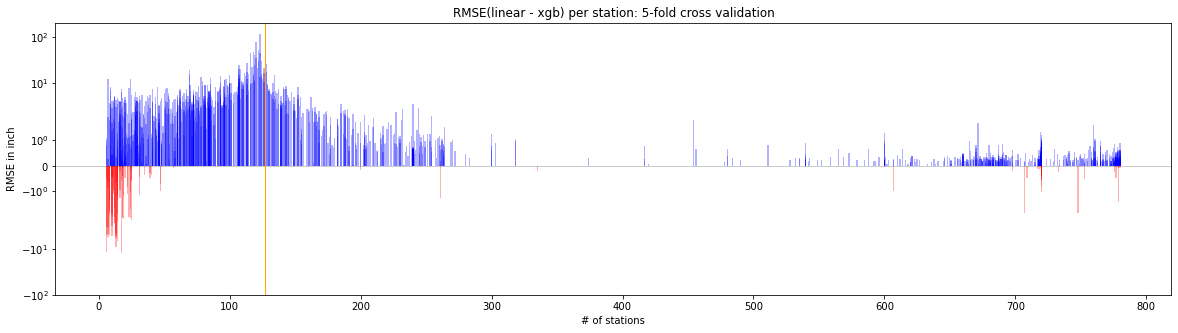

In [12]:
# df_stats = df_combined.groupby('skn').size().reset_index().rename(columns={0:"n_data"}).groupby("n_data").size().reset_index().rename(columns={0: "n_stations"})

fig, ax = plt.subplots(1, figsize=(20,5))
ax.bar(
    x=df_rmse['n_data'],
    height=df_rmse['diff'],
    width=1,
    color=['b' if item >= 0 else 'r' for item in df_rmse['diff']],
    alpha=0.3
)


ax.set_ylim((-100, 200))
ax.axhline(y=0, linestyle='-', linewidth=1, color='k', alpha=0.2)
ax.axvline(127, linewidth=1, color='orange')
ax.set_xlabel('# of stations')
ax.set_ylabel('RMSE in inch')
# ax.axhline(y=100, linewidth=1, linestyle='--')
    
ax.set_title("RMSE(linear - xgb) per station: 5-fold cross validation")
ax.set(yscale='symlog')
# plt.tight_layout()

# ax.scatter(df_stats['n_data'], df_stats['n_stations'], s=1, c='k', marker='x')
print()

(-200.0, 200.0)

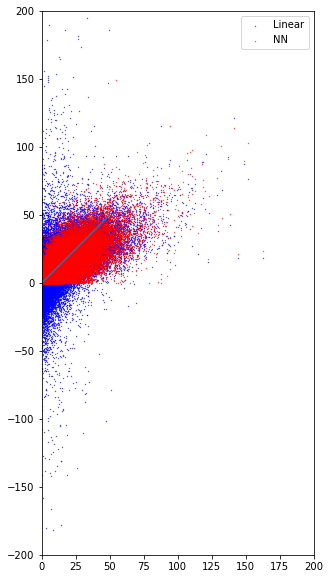

In [13]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.scatter(df_result['data_in'], df_result['pred_lr'], s=0.1, color='b', label='Linear')
ax.scatter(df_result['data_in'], df_result['pred_nn'], s=0.1, color='r', label='NN')
ax.plot([0, 50], [0, 50])
ax.set_aspect('equal')
ax.legend()
ax.set_xlim([0,200])
ax.set_ylim([-200,200])

In [30]:
df_combined[['skn', 'lat', 'lon']].drop_duplicates()

,skn,lat,lon
0,1.00,18.916176,-155.674994
1,2.00,19.108660,-155.825545
2,2.20,19.164740,-155.682280
3,2.25,19.160603,-155.822488
4,2.26,19.225323,-155.778876
...,...,...,...
540898,27.70,19.459400,-155.893800
541069,425.50,20.876100,-156.304700
2702,324.30,20.740136,-156.317187
41963,164.10,20.201653,-155.854711


In [38]:
df_rmse = pd.concat([rmse_per_station_linear, rmse_per_station_nn], axis=1).rename(columns={0: "rmse_linear", 1:"rmse_nn"})
df_rmse = df_rmse.merge(right=df_combined[['skn', 'lat', 'lon']].drop_duplicates(), left_on='skn', right_on='skn')
df_rmse['diff'] = df_rmse.apply(lambda row: row['rmse_linear'] - row['rmse_nn'], axis=1)

In [88]:
size = np.power(np.clip(df_rmse['diff'], a_min=-100, a_max=0), 2) + 1

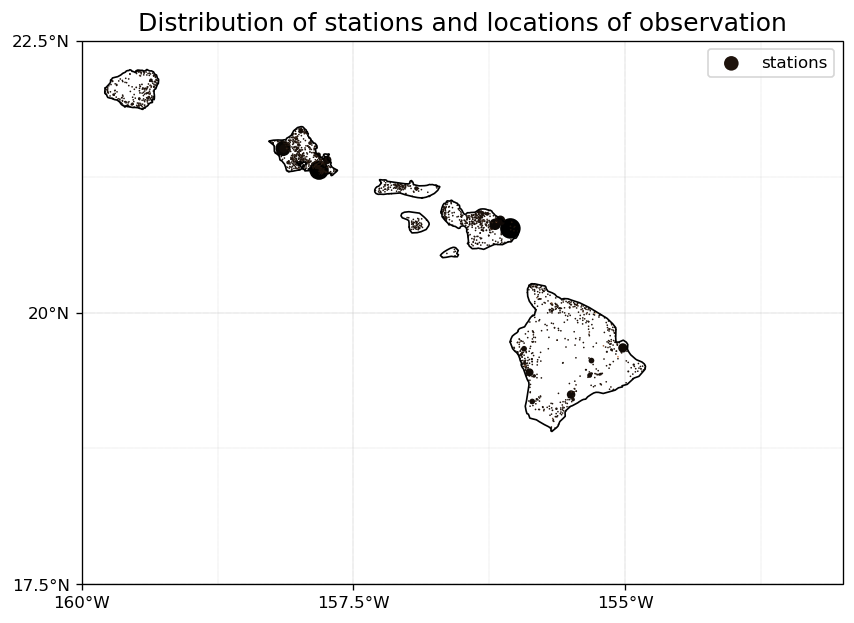

In [89]:
plt.figure(figsize=(10, 6), dpi=120)

ax = plt.axes(projection=ccrs.PlateCarree())

xmin, xmax = -160, -153
ymin, ymax = 17.5, 22.5

ax.set_xticks(np.arange(xmin, xmax+1, 2.5))
ax.set_yticks(np.arange(ymin, ymax+1, 2.5))

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.grid(linewidth=0.1, color='black', linestyle='--')

stations = plt.scatter(df_rmse["lon"], df_rmse["lat"], s=size, marker='o', c=df_rmse['diff'], label="stations", edgecolor='none', cmap='copper')
plt.vlines(x=np.arange(xmin, xmax+1, 2.5) - 1.25, ymin=ymin, ymax=ymax, color="k", linewidth=0.1, linestyle="--", alpha=0.5)
plt.hlines(y=np.arange(ymin, ymax+1, 2.5) - 1.25 , xmin=xmin, xmax=xmax, color="k", linewidth=0.1, linestyle="--", alpha=0.5)
plt.title("Distribution of stations and locations of observation", fontsize=(15))
plt.legend()
ax.coastlines(resolution='10m')
print()
# plt.savefig(f"{BASE_DIR}/images/reanalysis_grids.png")